In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime
import warnings
import numpy as np

from sklearn.preprocessing import minmax_scale
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from umap import UMAP

from pyuoi.decomposition import UoI_NMF

np.random.seed(10)

In [2]:
from pkg_resources import resource_filename
import h5py
input_path = resource_filename('pyuoi', 'data/Swimmer.h5')
f = h5py.File(input_path, 'r+')
Swimmers= f['Y'][:]
f.close()
Swimmers = Swimmers.T.reshape(256, 1024)
Swimmers = minmax_scale(Swimmers, axis=1)

Original Swimmer samples
=========================

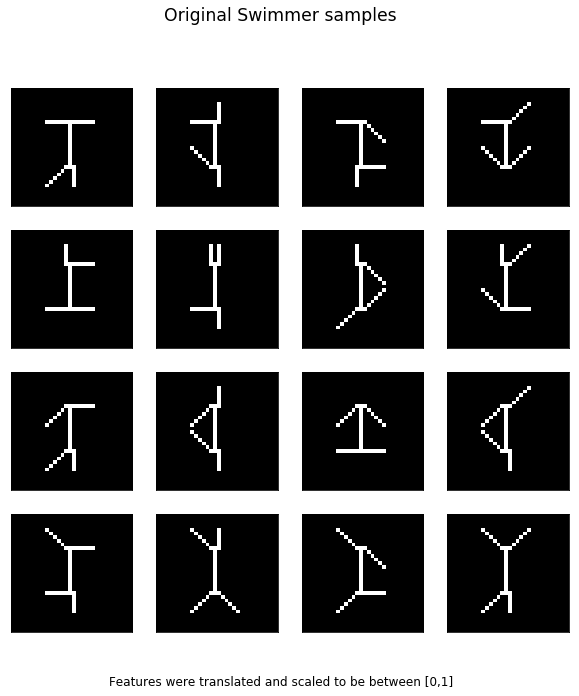

In [3]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
indices = np.random.randint(16, size=16) + np.arange(0, 256, 16)
ax = ax.flatten()
for i in range(len(indices)):
    ax[i].imshow(Swimmers[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
fig.suptitle("Original Swimmer samples", fontsize='xx-large', verticalalignment='center')
ret = fig.text(.5, .05, "Features were translated and scaled to be between [0,1]", ha='center', fontsize=12)

In [4]:
s = Swimmers.shape
reps = 10
corrupted = np.zeros((s[0]*reps, s[1]))

print("Corrupting %d replicates of Swimmer dataset with absolute Gaussian noise" % reps)

for r in range(reps):
    corrupted[r*s[0]:(r+1)*s[0]] = Swimmers + np.abs(np.random.normal(scale=0.25, size=Swimmers.shape))

Corrupting 10 replicates of Swimmer dataset with absolute Gaussian noise


Swimmer samples corrupted with Absolute Gaussian noise
======================================================
Noise was randomly sampled from |N(0,0.25)|

Text(0.5,0.05,'2560 samples were corrupted with absolute Gaussian noise drawn from a Normal(0, 0.25)')

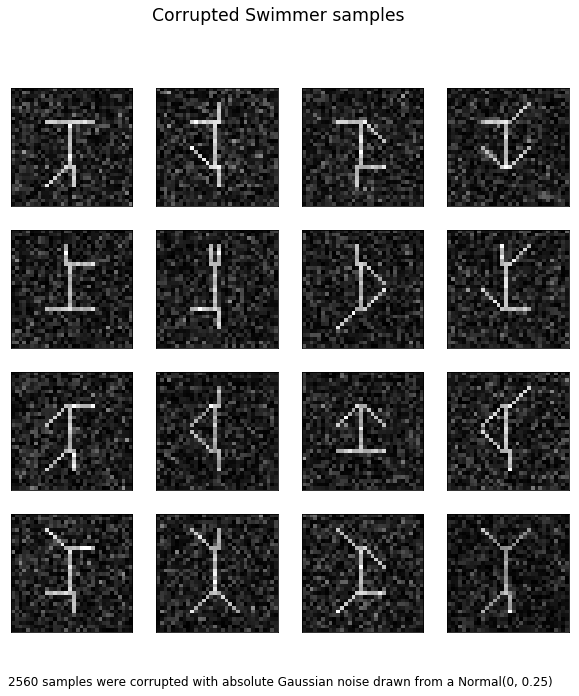

In [5]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(len(indices)):
    ax[i].imshow(corrupted[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
fig.suptitle("Corrupted Swimmer samples ", fontsize='xx-large', verticalalignment='center')
fig.text(.5, .05, "%d samples were corrupted with absolute Gaussian noise drawn from a Normal(0, 0.25)" % corrupted.shape[0], ha='center', fontsize=12)

In [6]:
nboot = 20
min_pts = nboot/2
ranks = [16]

shape = corrupted.shape

uoinmf = UoI_NMF(n_boots=nboot, ranks=ranks,
                db_min_samples=min_pts,
                nmf_max_iter=400,)

print(repr(uoinmf))

uoinmf.cons_meth = np.mean   # intersect and mean give too much noise

transformed = None
before = datetime.now()
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter('ignore', ConvergenceWarning)
    transformed = uoinmf.fit_transform(corrupted)
    print("Caught %d ConvergenceWarnings" % len(w))
after = datetime.now()
recovered = transformed @ uoinmf.components_

embedding = TSNE(n_components=2).fit_transform(uoinmf.bases_samples_)
bases = uoinmf.components_

print("Took %s." % (after - before), "Found %s bases" % bases.shape[0])

UoI_NMF(db_algorithm=None, db_eps=None, db_leaf_size=None, db_metric=None,
        db_metric_params=None, db_min_samples=None, logger=None, n_boots=20,
        nmf_beta_loss=None, nmf_init=None, nmf_max_iter=None, nmf_solver=None,
        nmf_tol=None, random_state=None, ranks=(16,))
Caught 0 ConvergenceWarnings
Took 0:04:11.255903. Found 16 bases


NMF Swimmer bases
=================

(16, 1024)


Text(0.5,0.05,'UoINMF was run with 20 bootstrap replicates.\nNMF bases were clustered using DBSCAN with minPts=10 and eps=0.5\nconsensus bases were computing by taking the median of all members in each cluster')

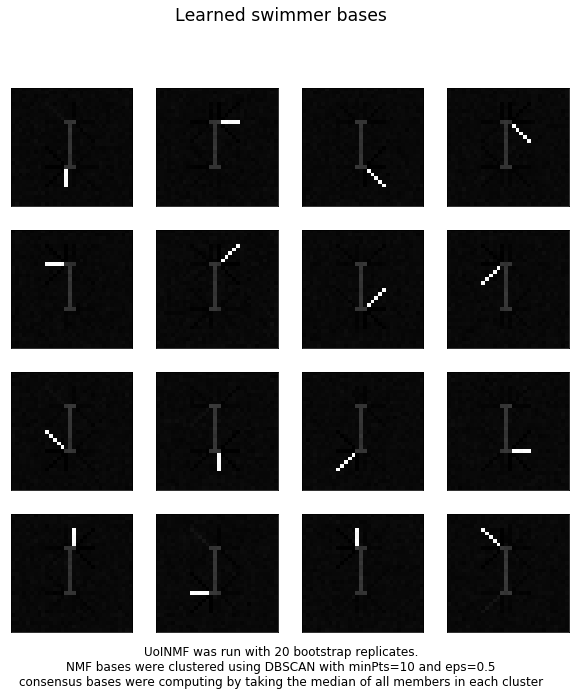

In [7]:

print(bases.shape)
order = np.argsort(np.sum(bases, axis=1))

nrow = 5 if bases.shape[0] > 16 else 4

fig, ax = plt.subplots(nrow,4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(bases.shape[0]):
    ax[i].imshow(bases[order[i]].reshape(32,32).T, aspect='auto', cmap='gray')
fig.suptitle("Learned swimmer bases", fontsize='xx-large', verticalalignment='center')

caption = ("UoINMF was run with 20 bootstrap replicates.\n"
           "NMF bases were clustered using %s with minPts=%d and eps=0.5\n"
           "consensus bases were computing by taking the median of all members in each cluster")

caption = caption % ('DBSCAN', min_pts)

fig.text(.5, .05, caption, ha='center', fontsize=12)

Recovered Swimmers
==================

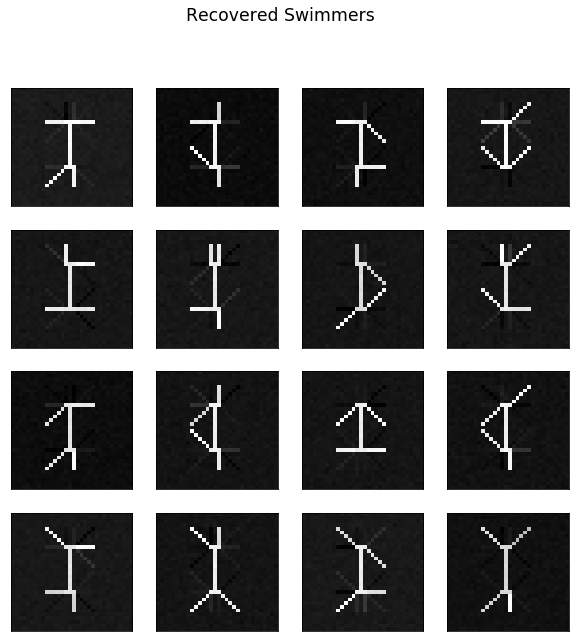

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(len(indices)):
    ax[i].imshow(recovered[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
    
ret = fig.suptitle("Recovered Swimmers", fontsize='xx-large', verticalalignment='center')

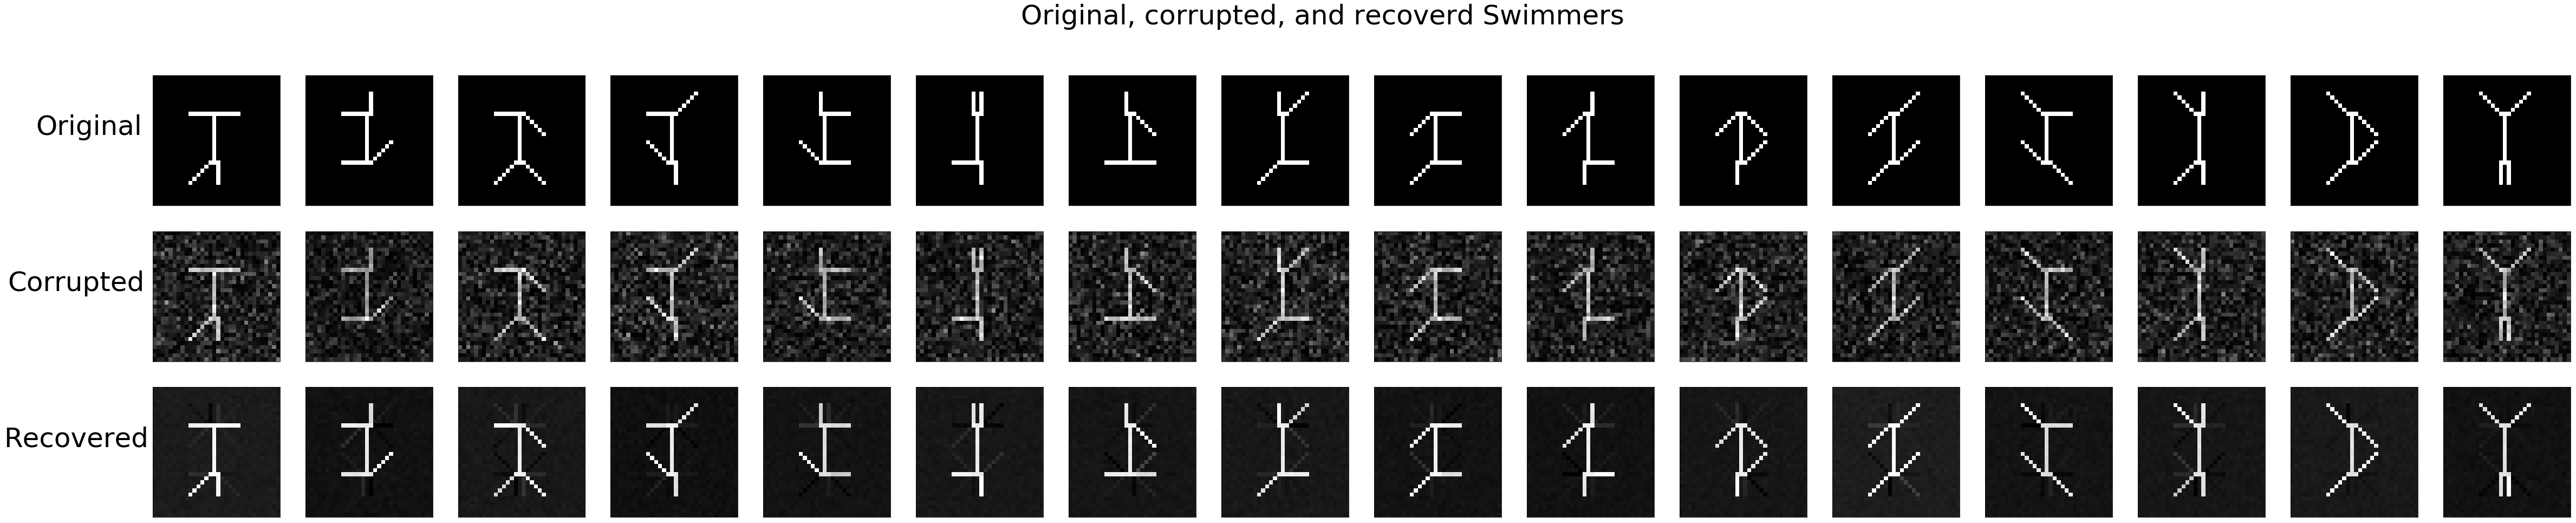

In [9]:
fig, ax = plt.subplots(3, 16, figsize=(80, 15), subplot_kw={'xticks': [], 'yticks': []})
indices = np.random.randint(16, size=16) + np.arange(0, 256, 16)
ax = ax.flatten()

# plot Original
ax[0].set_ylabel('Original', rotation=0, fontsize=50, labelpad=20)
ax[0].yaxis.set_label_coords(-0.5, 0.5)
for i in range(len(indices)):
    ax[i].imshow(Swimmers[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
    
# plot Corrupted
ax[16].set_ylabel('Corrupted', rotation=0, fontsize=50, labelpad=20)
ax[16].yaxis.set_label_coords(-0.6, 0.5)
for i in range(len(indices)):
    ax[16+i].imshow(corrupted[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
    
# plot Recovered
ax[32].set_ylabel('Recovered', rotation=0, fontsize=50, labelpad=20)
ax[32].yaxis.set_label_coords(-0.6, 0.5)
for i in range(len(indices)):
    ax[32+i].imshow(recovered[indices[i]].reshape(32,32).T, aspect='auto', cmap='gray')
    
ret = fig.suptitle("Original, corrupted, and recoverd Swimmers", fontsize=50, verticalalignment='center')

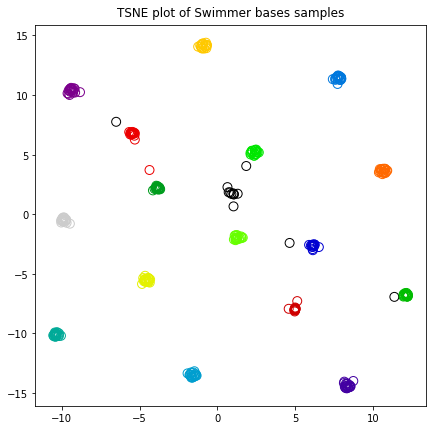

In [10]:
plt.figure(figsize=(7,7))
sc = plt.scatter(embedding[:,0], embedding[:,1], c=uoinmf.bases_samples_labels_, s=80, cmap="nipy_spectral")
sc.set_facecolor('none')

ret = plt.title("TSNE plot of Swimmer bases samples", fontsize='large', verticalalignment='bottom')

In [15]:
def add_dset(g, name, dat, desc):
    dset = g.require_dataset(name, shape=dat.shape, dtype=dat.dtype)
    dset[...] = dat
    dset.attrs['description'] = desc
    return dset

output_path = "Swimmer_uoinmf_results.h5"
f = h5py.File(output_path, 'w')
Swimmers = Swimmers.T.reshape((256, 32*32))
Swimmers = minmax_scale(Swimmers, axis=1)
dset = add_dset(f, 'Swimmers', Swimmers, "reshaped and scaled to [0,1]")
dset = add_dset(f, 'Swimmers_corrupted', corrupted, "Swimmers with absolute random noise i.e. |N(0, 0.25)|")
dset = add_dset(f, 'Swimmers_bases_samples', uoinmf.bases_samples_, 'generated with UoINMF: %s' % repr(uoinmf))
dset = add_dset(f, 'Swimmers_bases', uoinmf.components_, 'generated with UoINMF: %s' % repr(uoinmf))
dset = add_dset(f, 'Swimmers_bases_samples_embeddings', embedding, 'generated with TSNE')
f.close()